In [1]:
# geospatial
import geopandas as gpd
import rasterio
from rasterio import features
from osgeo import gdal, ogr, osr

# base
import pandas as pd
import numpy as np
import os, itertools, time
from multiprocessing import Pool, cpu_count

# iteration prints 
from IPython.display import clear_output

# plotting
import matplotlib.pyplot as plt

# stats
from scipy import stats

In [2]:
# folder locations
scratch = os.path.join("H:\\", "scratch")
shapefiles = os.path.join("..", "data", "shapefiles")

merged = os.path.join("H:\\", "Merged")
h_mask_loc = os.path.join(merged, "harvest_mask", "harvest_mask.tif")
masked_structure_locs = os.path.join(merged, "masked_structure")

struct_vars = os.listdir(masked_structure_locs)

In [3]:
# keys
structure_key = pd.read_csv(os.path.join("..", "keys", "structure.csv"))

In [4]:
ppa_bec = gpd.read_file(os.path.join(shapefiles, "bc_ppa_bec_hres.shp"))

In [5]:
# some generic cleaning of the gdf
# calculate area for each polygon
ppa_bec["Shap_Ar"] = ppa_bec.area

# assign a protected column to the df
# this lambda thing is like a local function apparently? im not entirely sure whats going on
# but it works correctly.
ppa_bec = ppa_bec.assign(protected = lambda dataframe: dataframe["NAME_E"].map(lambda NAME_E: True if NAME_E else False))

# create a unique value for zone/subzones
ppa_bec["szs"] = ppa_bec["zone"] + "_" + ppa_bec["subzone"]

# filter out any without bec zones (generally sliver polygons)
ppa_bec = ppa_bec[ppa_bec["szs"].notnull()]

ppa_bec = ppa_bec[["szs", "geometry", "zone", "subzone", "protected", "Shap_Ar"]]
ppa_bec["raster"] = 1

In [6]:
subzones = sorted(list(set(ppa_bec["szs"])))

# BAFA_un is the testing one
# soi is going to be the iterable
# for soi in subzones:
soi = subzones[0] # BAFA_un

# equal sampling of pixels THEN remove non-forest or remove non-forest then equal sampling of pixels?

In [7]:
def rasterize_polygon_mask(gpd, out_loc, meta):
    # rasterizes a polygon. requires a field in gpd named 'raster'
    # masks out harvested pixels. requires
    with rasterio.open(out_loc, "w+", **meta) as out:
        out_arr = out.read(1)

        shapes = ((geom,value) for geom, value in zip(gpd.geometry, gpd.raster))

        burned = features.rasterize(shapes = shapes, fill = 0, out = out_arr, transform = out.transform)

        # removes pixels impacted by harvest
        burned = burned * h_mask_data

        out.write_band(1, burned)
        
        return burned

def sample_raster(mask, save_loc, big, small):
    
    sampled_loc = save_loc[:-4] + "-sampled" + save_loc[-4:]
    
    indexes = np.where(mask == 1)
    good_indexes = np.random.choice(np.arange(0, big), size = small, replace = False)
    
    x = indexes[0][good_indexes]
    y = indexes[1][good_indexes]

    blank = np.zeros(mask.shape, dtype = "uint8")
    blank[x, y] = 1

    with rasterio.open(sampled_loc, "w+", **meta) as out:
        out_arr = out.read(1)

        out.write_band(1, blank)
    
    return blank

def equal_sample_p_np(soi):
    np.random.seed(69420)
    
    # filter ppa for the subzone of interest
    subzone_filter = ppa_bec[ppa_bec["szs"] == soi]
    
    # split into protected/non protected shapefiles and save them (not sure its necessary to save)
    # selected protected shapes
    p_sub = subzone_filter[subzone_filter["protected"]]
    p_sub = p_sub.dissolve(by = "szs")
    p_sub.to_file(os.path.join(scratch, "p-" + soi + ".shp"))

    # select unprotected shapes
    np_sub = subzone_filter[subzone_filter["protected"] == False]
    np_sub = np_sub.dissolve(by = "szs")
    np_sub.to_file(os.path.join(scratch, "np-" + soi + ".shp"))
    
    #save locations
    p_raster_loc = os.path.join(scratch, "p-" + soi + ".tif")
    np_raster_loc = os.path.join(scratch, "np-" + soi + ".tif")
    
    p_mask = rasterize_polygon_mask(p_sub, p_raster_loc, meta)
    np_mask = rasterize_polygon_mask(np_sub, np_raster_loc, meta)
    
    

    p_pixels = np.sum(p_mask)
    np_pixels = np.sum(np_mask)  
    
    if p_pixels < np_pixels:
        np_sampled = sample_raster(np_mask, np_raster_loc, np_pixels, p_pixels)
        p_sampled = p_mask
    
    else:
        p_sampled = sample_raster(p_mask, p_raster_loc, p_pixels, np_pixels)
        np_sampled = np_mask
            
    return p_sampled, np_sampled

def get_data(mask, variable, year):
    if variable in struct_vars:
        divisor = structure_key[structure_key["variable"] == "total_biomass"].iloc[0]["divide_by"]
        file_loc = os.path.join(masked_structure_locs, variable, "masked-" + variable + "-" + str(year) + ".tif")
        
    elif variable == "Change_Attribution":
        file_loc = os.path.join(merged, variable, "BC-" + variable + ".tif")
        
    elif variable == "vlce":
        file_loc = os.path.join(merged, variable, "BC-" + variable + "-" + str(year) + ".tif")
        
    else:
        print("Not a valid variable")
        return

    with rasterio.open(file_loc) as rst:
        rst_data = rst.read(1)
        
    indexes = np.where(mask == 1)
    x = indexes[0]
    y = indexes[1]

    data_arr = rst_data[x, y]
    
    if variable in struct_vars:
        data_arr = data_arr[np.where(data_arr != 0)]
        return data_arr / divisor
    else:
        return data_arr

In [8]:
soi = "SBPS_xc"

h_mask = rasterio.open(h_mask_loc)
h_mask_data = h_mask.read(1)
meta = h_mask.meta.copy()
meta["nodata"] = 0

sampled_rasters = equal_sample_p_np(soi)

del h_mask
del h_mask_data

In [23]:
variable = "vlce"
year = 2015

In [31]:
def categorical_df(masks, variable, year):
    p_cat = get_data(masks[0], variable, year)
    
    counts = np.transpose(np.unique(p_cat, return_counts = True))

    df1 = pd.DataFrame(counts, columns = ["class_val", "cells"])
    df1["protected"] = True
    
    np_cat = get_data(masks[1], variable, year)
    
    counts = np.transpose(np.unique(np_cat, return_counts = True))
    
    df2 = pd.DataFrame(counts, columns = ["class_val", "cells"])
    df2["protected"] = False
    
    df = pd.concat([df1, df2])
    
    df["subzone"] = soi
    df["year"] = year
    df["variable"] = variable

    return df

In [33]:
categorical_df(sampled_rasters, "Change_Attribution", 2015)

,class_val,cells,protected,subzone,year,variable
0,0,227893,True,SBPS_xc,2015,Change_Attribution
1,1,163773,True,SBPS_xc,2015,Change_Attribution
2,3,22252,True,SBPS_xc,2015,Change_Attribution
3,5,3979,True,SBPS_xc,2015,Change_Attribution
4,6,409,True,SBPS_xc,2015,Change_Attribution
5,7,1627,True,SBPS_xc,2015,Change_Attribution
6,9,168,True,SBPS_xc,2015,Change_Attribution
7,10,529,True,SBPS_xc,2015,Change_Attribution
0,0,309362,False,SBPS_xc,2015,Change_Attribution
1,1,52883,False,SBPS_xc,2015,Change_Attribution


In [34]:
p_biomass = get_data(sampled_rasters[0], variable, year)
np_biomass = get_data(sampled_rasters[1], variable, year)
stats.ttest_ind(p_biomass, np_biomass)

array([40.63, 38.44, 48.36, ..., 43.44, 79.77, 79.77])

(0.0, 45000.0)

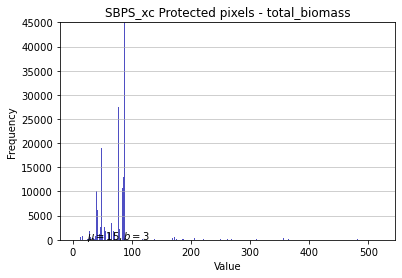

In [14]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=p_biomass, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(soi + ' Protected pixels - ' + variable)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=45000)


(0.0, 45000.0)

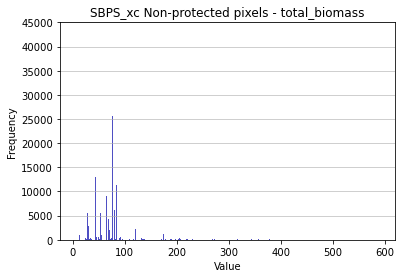

In [19]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=np_biomass, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(soi + ' Non-protected pixels - ' + variable)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax = 45000)


import os, shutil

for filename in os.listdir(scratch):
    file_path = os.path.join(scratch, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))